# Loan Repayment 
## Predictive Modelling

<font size='3'>
This notebook will cover three main sections: Feature Selection, Data Preparation, and Predictive Modelling. <b> The final outcome will be binary classification machine learning models which will be used to predict whether a funded loan will be paid off or defaulted using selected features.</b> It is highly recommended to go through data_transform.ipynb and eda.ipynb before jumping into this notebook.<br><br>

The target variable in for this classification problem will be the 'paidOff'; it indicates whether a completed funded loan receives payment as originally scheduled or not (True/False).<br><br>

In this loan repayment task, <b>there is more focus on data-centric approach rather than model-centric.</b> Therefore, there is minimal optimization for model experimentation for now.
</font>

In [1]:
import os
# Change directory to this file's directory
this_path = globals()['_dh'][-1]
os.chdir(this_path)
print("This file's directory:", os.getcwd())
# Change current path to parent of this file's directory
# to access all modules from parent
os.chdir('..')
source_path = os.getcwd()
print("Parent directory:", source_path)

This file's directory: /home/mattkhoo/Git-Loan-Repayment-EDA-Predictive/notebooks
Parent directory: /home/mattkhoo/Git-Loan-Repayment-EDA-Predictive


In [2]:
from main.data_loader import DataLoader
%matplotlib inline

In [3]:
# Load transformed data
os.chdir(source_path)
feather_path = os.path.join(str(os.getcwd()),'data-feathers') 
data_manager = DataLoader()
load_path = os.path.join(feather_path, 'transformed')
data_manager.load_feather(load_path)
print("Shape of transformed data:", data_manager.data.shape)
data_manager.display(5, True)

Shape of transformed data: (30672, 15)


,payFrequency,apr,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,hasCF,applicationYear,paymentAmount,paidOff,clearfraudscore
0,B,199.0,0.0,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,1,2016,6287.08,False,879.0
1,S,490.0,2.0,Paid Off Loan,1250.0,3313.78,MO,organic,0,Checked,1,2017,1333.75,False,835.0
2,B,590.0,0.0,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,Checked,1,2016,2432.08,True,624.0
3,W,404.1,3.0,Paid Off Loan,300.0,422.64,WI,organic,0,Checked,1,2016,395.94,False,770.0
4,B,315.0,2.0,Internal Collection,1500.0,2875.27,IL,organic,0,Rejected,1,2017,0.00,False,932.0


## Feature Selection
<font size='3'> The decisions made here are mainly supported by insights gained in the correlation section of eda.ipynb.<br><br>
Summary of decisions:</font>

- <font size='3'> Payment amount and originally scheduled payment variables will be removed as the target variable is derived from these values.</font><br><br>
- <font size='3'> Loan amount will be kept since payment amount and scheduled amount are removed.</font><br><br>
- <font size='3'> Loan status is removed due to being a dynamic variable and a contender to the target variable, hence not suitable as a predictor.</font><br><br>
- <font size='3'> Lead cost is considered a redundancy as there is lead type.</font><br><br>
- <font size='3'> Year is removed as it is not a useful variable, instead loan term would be a better variable related to time, but data on loan term is not found.</font>

In [4]:
# Drop the chosen columns
dropped_cols = ['loanStatus', 'originallyScheduledPaymentAmount', 'paymentAmount', 'leadCost', 'applicationYear']
data_manager.drop_column(dropped_cols)

## Data Preparation
<font size='3'> The processes detailed below will be performed in consideration of tree-based models for now. Tree-based models are prioritzed in experimentation due to the <b>much smaller number of features compared to data records/instances available.</b> Tree-based algorithms also have higher interpretability compared to SVM, neural networks, and other complex methods.<br><br>

Summary of data preprocessing:</font>

- <font size='3'> Ordinal encoding for categorical predictors.</font><br><br>
- <font size='3'> Standard scaling continuous predictors.</font><br><br>
- <font size='3'> Label encoding for target variable.</font>

In [5]:
# Convert all categorical variables accordingly
data_manager.convert_dtype(origin='object', target='category')  # object (string) to category
data_manager.convert_dtype(origin='bool', target='category') # boolean to category
to_cat = ['hasCF', 'nPaidOff']
data_manager.column_to_cat(to_cat)  # convert selected columns to 'category'

In [6]:
# Separate target variable from predictors
y = data_manager.data.paidOff
data_manager.drop_column(['paidOff'])

In [7]:
# Check predictor columns
predictor_cols = data_manager.data.columns.values.tolist()
print ("Predictor Columns:", predictor_cols)

Predictor Columns: ['payFrequency', 'apr', 'nPaidOff', 'loanAmount', 'state', 'leadType', 'fpStatus', 'hasCF', 'clearfraudscore']


In [8]:
# Verify categorical and continuous variables first
cat_cols = data_manager.cat_col_names()
cont_cols = data_manager.noncat_col_names()
print("Categorical predictors:", cat_cols)
print("Continuous predictors:", cont_cols)

Categorical predictors: ['payFrequency', 'nPaidOff', 'state', 'leadType', 'fpStatus', 'hasCF']
Continuous predictors: ['apr', 'loanAmount', 'clearfraudscore']


In [9]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [10]:
# Create and fit pipelines accordingly for predictors
pipeline = ColumnTransformer([
    ('num_scaler', StandardScaler(), cont_cols),
    ('cat_enc', OrdinalEncoder(), cat_cols)
    ], remainder='passthrough')

x_prep = pipeline.fit_transform(data_manager.data)
print(x_prep.shape)

(30672, 9)


In [11]:
# Encode the target variable
y_prep = LabelEncoder().fit_transform(y)
print(y_prep.shape)

(30672,)


In [12]:
# Split into train-validation
# Stratify on target variable to ensure balanced class split
x_train, x_val, y_train, y_val = train_test_split(x_prep, y_prep, test_size=0.3, stratify=y_prep, random_state=12345)
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

(21470, 9) (9202, 9)
(21470,) (9202,)


# Predictive Modelling
<font size='3'> In this section, experiments on various models will be performed, covering both baseline and novel approaches. The models used here will be saved in the 'models' directory. <br>
<b>ROC-AUC will be the key metric to measure performance</b>, as observed earlier in eda.ipynb that the target variable is imbalanced.<br><br>
</font>

In [13]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from main import  modelling_utils as mod

In [14]:
# Dictionary for utils functions
train = {0: x_train, 1: y_train}
val = {0: x_val, 1: y_val}

## Baseline - Decision Tree

Training score: 0.9998268808596811
Validation score:  0.5689118666196715


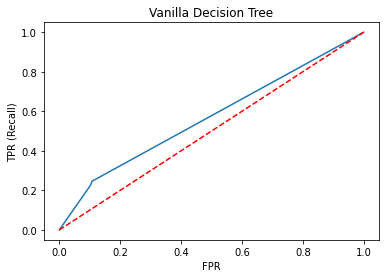

In [15]:
vanilla_dt = DecisionTreeClassifier()
vanilla_dt.fit(x_train, y_train)
train_roc_auc, val_roc_auc = mod.evaluate_roc_auc(vanilla_dt, train, val)
print("Training score:", train_roc_auc)
print("Validation score: ", val_roc_auc)
mod.plot_roc(vanilla_dt, val, "Vanilla Decision Tree")

## Novel - Random Forest (Bagging)

Training score: 0.999735147090068
Validation score:  0.7197237128857867


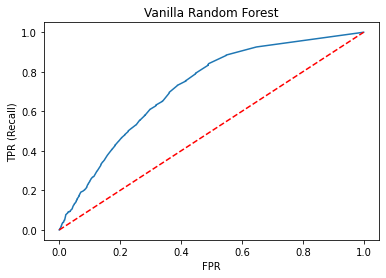

In [16]:
vanilla_rf = RandomForestClassifier()
vanilla_rf.fit(x_train, y_train)
train_roc_auc, val_roc_auc = mod.evaluate_roc_auc(vanilla_rf, train, val)
print("Training score:", train_roc_auc)
print("Validation score: ", val_roc_auc)
mod.plot_roc(vanilla_rf, val, "Vanilla Random Forest")

## Novel - Adaptive Boosting (AdaBoost)

Training score: 0.7881091813525225
Validation score:  0.7625559102259245


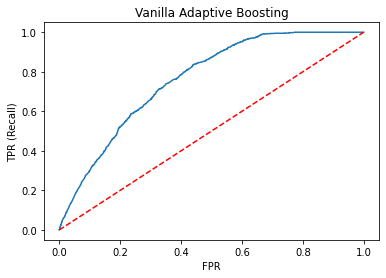

In [17]:
vanilla_ada = AdaBoostClassifier()
vanilla_ada.fit(x_train, y_train)
train_roc_auc, val_roc_auc = mod.evaluate_roc_auc(vanilla_ada, train, val)
print("Training score:", train_roc_auc)
print("Validation score: ", val_roc_auc)
mod.plot_roc(vanilla_ada, val, "Vanilla Adaptive Boosting")

## Novel - XGBoost

[13:02:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training score: 0.9149236015774334
Validation score:  0.7798948440967239


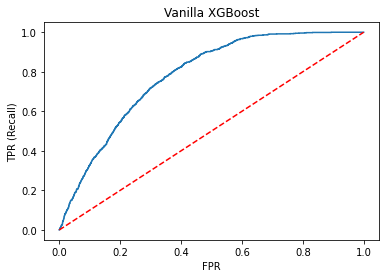

In [18]:
vanilla_xgb = xgb.XGBClassifier(use_label_encoder=False)
vanilla_xgb.fit(x_train, y_train)
train_roc_auc, val_roc_auc = mod.evaluate_roc_auc(vanilla_xgb, train, val)
print("Training score:", train_roc_auc)
print("Validation score: ", val_roc_auc)
mod.plot_roc(vanilla_xgb, val, "Vanilla XGBoost")

In [ ]:
# Save models as object pickles
from pickle import dump
os.chdir(source_path)
models_path = os.path.join(str(os.getcwd()),'models')
stratified_70_30_path = os.path.join(models_path, 'stratified_70_30')
dump(vanilla_dt, open(os.path.join(stratified_70_30_path, 'vanilla_dt.pkl'), 'wb'))
dump(vanilla_rf, open(os.path.join(stratified_70_30_path, 'vanilla_rf.pkl'), 'wb'))
dump(vanilla_ada, open(os.path.join(stratified_70_30_path, 'vanilla_ada.pkl'), 'wb'))
dump(vanilla_xgb, open(os.path.join(stratified_70_30_path, 'vanilla_xgb.pkl'), 'wb'))